### Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

**Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.**

### Data
We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.

Variable|Description   
:---- |:----
Item_Identifier|Unique product ID
Item_Weight|Weight of product
Item_Fat_Content|Whether the product is low fat or not
Item_Visibility|The % of total display area of all products in a store allocated to the particular product
Item_Type|The category to which the product belongs
Item_MRP|Maximum Retail Price (list price) of the product
Outlet_Identifier|Unique store ID
Outlet_Establishment_Year|The year in which store was established
Outlet_Size|The size of the store in terms of ground area covered
Outlet_Location_Type|The type of city in which the store is located
Outlet_Type|Whether the outlet is just a grocery store or some sort of supermarket
Item_Outlet_Sales|Sales of the product in the particular store. This is the outcome variable to be predicted.

### Evaluation Metric:

Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in "SampleSubmission.csv".

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the **Root Mean Square Error** value to judge your response.



Where,
N: total number of observations
Predicted: the response entered by user
Actual: actual values of sales

Also, note that the test data is further divided into Public (25%) and Private (75%) data. Your initial responses will be checked and scored on the Public data. But, the final rankings will be based on score on Private data set. Since this is a practice problem, we will keep declare winners after specific time intervals and refresh the competition.
 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import scipy.stats as st
from matplotlib import pyplot as plt

In [3]:
from catboost import CatBoostRegressor

In [4]:
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()


def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

In [5]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

def get_predictors(df, target):
    return [col for col in df.columns if col != target]

def extended_describe(dataframe):
    extended_describe_df = dataframe.describe(include='all').T
    extended_describe_df['null_count'] = dataframe.isnull().sum()
    extended_describe_df['unique_count'] = dataframe.apply(
        lambda x: len(x.unique()))
    return extended_describe_df

In [6]:
target = 'Item_Outlet_Sales'

train_file = 'train.csv'
test_file = 'test.csv'

In [7]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [8]:
test_df_copy = test_df.copy()

In [9]:
predictors = get_predictors(train_df, target)

In [10]:
extended_describe(train_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count,unique_count
Item_Identifier,8523,1559,FDW13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1559
Item_Weight,7060.0000,NaN,NaN,NaN,12.8576,4.6435,4.5550,8.7737,12.6000,16.8500,21.3500,1463,416
Item_Fat_Content,8523,5,Low Fat,5089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
Item_Visibility,8523.0000,NaN,NaN,NaN,0.0661,0.0516,0.0000,0.0270,0.0539,0.0946,0.3284,0,7880
Item_Type,8523,16,Fruits and Vegetables,1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16
Item_MRP,8523.0000,NaN,NaN,NaN,140.9928,62.2751,31.2900,93.8265,143.0128,185.6437,266.8884,0,5938
Outlet_Identifier,8523,10,OUT027,935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10
Outlet_Establishment_Year,8523.0000,NaN,NaN,NaN,1997.8319,8.3718,1985.0000,1987.0000,1999.0000,2004.0000,2009.0000,0,9
Outlet_Size,6113,3,Medium,2793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2410,4
Outlet_Location_Type,8523,3,Tier 3,3350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3


In [11]:
extended_describe(test_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count,unique_count
Item_Identifier,5681,1543,FDW10,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1543
Item_Weight,4705.0000,NaN,NaN,NaN,12.6956,4.6648,4.5550,8.6450,12.5000,16.7000,21.3500,976,411
Item_Fat_Content,5681,5,Low Fat,3396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
Item_Visibility,5681.0000,NaN,NaN,NaN,0.0657,0.0513,0.0000,0.0270,0.0542,0.0935,0.3236,0,5277
Item_Type,5681,16,Snack Foods,789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16
Item_MRP,5681.0000,NaN,NaN,NaN,141.0233,61.8091,31.9900,94.4120,141.4154,186.0266,266.5884,0,4402
Outlet_Identifier,5681,10,OUT027,624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10
Outlet_Establishment_Year,5681.0000,NaN,NaN,NaN,1997.8289,8.3723,1985.0000,1987.0000,1999.0000,2004.0000,2009.0000,0,9
Outlet_Size,4075,3,Medium,1862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1606,4
Outlet_Location_Type,5681,3,Tier 3,2233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3


In [12]:
data = pd.concat([train_df, test_df], ignore_index=True)
visibility_avg = data.groupby(['Item_Identifier'])['Item_Visibility'].agg(pd.Series.mean)

# Impute 0 values with mean train_df of that product:
miss_bool = (train_df['Item_Visibility'] == 0)
miss_test_bool = (test_df['Item_Visibility'] == 0)

print('Number of 0 values initially: ', sum(miss_bool))
print('Number of 0 test values initially: ', sum(miss_test_bool))

train_df.loc[miss_bool, 'Item_Visibility'] = train_df.loc[miss_bool, 'Item_Identifier'].apply(lambda x: visibility_avg.get(x, 0))
test_df.loc[miss_test_bool, 'Item_Visibility'] = test_df.loc[miss_test_bool,'Item_Identifier'].apply(lambda x: visibility_avg.get(x, 0))
print('Number of 0 values after modification: ',sum(train_df['Item_Visibility'] == 0))
print('Number of 0 values after modification: ',sum(test_df['Item_Visibility'] == 0))

Number of 0 values initially:  526
Number of 0 test values initially:  353
Number of 0 values after modification:  0
Number of 0 values after modification:  0


In [13]:
item_avg_weight = data.groupby(['Item_Identifier'])['Item_Weight'].agg(pd.Series.mean)

# Get a boolean variable specifying missing Item_Weight values
miss_train_bool = train_df['Item_Weight'].isnull()
miss_test_bool = test_df['Item_Weight'].isnull()

# Impute data and check #missing values before and after imputation to confirm
print('Original #missing:', sum(miss_train_bool))
print('Original #missing:', sum(miss_test_bool))

train_df.loc[miss_train_bool, 'Item_Weight'] = train_df.loc[miss_train_bool,
                                                            'Item_Identifier'].apply(lambda x: item_avg_weight.get(x, None))
test_df.loc[miss_test_bool, 'Item_Weight'] = test_df.loc[miss_test_bool,
                                                         'Item_Identifier'].apply(lambda x: item_avg_weight.get(x, None))

print('Final #missing: ', sum(train_df['Item_Weight'].isnull()))
print('Final #missing: ', sum(test_df['Item_Weight'].isnull()))

Original #missing: 1463
Original #missing: 976
Final #missing:  0
Final #missing:  0


In [14]:
outlet_location_mode =data.groupby(['Outlet_Location_Type'])['Outlet_Size'].agg(pd.Series.mode)

# Get a boolean variable specifying missing Item_Weight values
miss_train_bool = train_df['Outlet_Size'].isnull()
miss_test_bool = test_df['Outlet_Size'].isnull()

# Impute data and check #missing values before and after imputation to confirm
print('Orignal #missing:', sum(miss_train_bool))
print('Orignal #missing:', sum(miss_test_bool))

train_df.loc[miss_train_bool, 'Outlet_Size'] = train_df.loc[miss_train_bool,
                                                            'Outlet_Location_Type'].apply(lambda x: outlet_location_mode.get(x, None))
test_df.loc[miss_test_bool, 'Outlet_Size'] = test_df.loc[miss_test_bool,
                                                         'Outlet_Location_Type'].apply(lambda x: outlet_location_mode.get(x, None))

print('Final #missing: ', sum(train_df['Outlet_Size'].isnull()))
print('Final #missing: ', sum(test_df['Outlet_Size'].isnull()))

Orignal #missing: 2410
Orignal #missing: 1606
Final #missing:  0
Final #missing:  0


In [15]:
def get_item_identifier(row):
    return row['Item_Identifier'][:2]

#train_df['Item_Identifier_New'] = train_df.apply(get_item_identifier, axis=1)
#test_df['Item_Identifier_New'] = test_df.apply(get_item_identifier, axis=1)

In [16]:
replace_fc = {'LF': 'Low Fat', 'low fat': 'Low Fat', 'low fat': 'Low Fat',
              'reg': 'Regular', 'Low Fat': 'Low Fat', 'Regular': 'Regular'}

train_df['Item_Fat_Content'].value_counts()

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].map(replace_fc)
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].map(replace_fc)

In [17]:
train_df['Years'] = train_df['Outlet_Establishment_Year'].apply(
    lambda x: 2013 - x)
test_df['Years'] = test_df['Outlet_Establishment_Year'].apply(
    lambda x: 2013 - x)

In [18]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                5681 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                5681 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
 11  Years                      5681 non-null   int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 532.7+ KB


In [19]:
#train_df.fillna(-999,inplace=True)
#test_df.fillna(-999,inplace=True)

In [20]:
# train_df['isOutlet_27'] = train_df['Outlet_Identifier'].apply(
#     lambda x: 'Y' if x == 'OUT027' else 'N')
# test_df['isOutlet_27'] = test_df['Outlet_Identifier'].apply(
#     lambda x: 'Y' if x == 'OUT027' else 'N')

In [21]:
# train_df['isOutlet_10_or_19'] = train_df['Outlet_Identifier'].apply(
#     lambda x: 'Y' if x in ('OUT010', 'OUT019') else 'N')
# test_df['isOutlet_10_or_19'] = test_df['Outlet_Identifier'].apply(
#     lambda x: 'Y' if x in ('OUT010', 'OUT019') else 'N')

In [22]:
# mean_visibility=train_df['Item_Visibility'].mean()

# train_df['Item_Visibility_MeanRatio']=train_df.apply(lambda x:x['Item_Visibility']/mean_visibility,axis=1)
# test_df['Item_Visibility_MeanRatio']=test_df.apply(lambda x:x['Item_Visibility']/mean_visibility,axis=1)

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  Years                      8523 non-null   int64  
dtypes: float64(4), int64(2), object(7)
memory usage:

In [24]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                5681 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                5681 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
 11  Years                      5681 non-null   int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 532.7+ KB


In [25]:
# def encode_to_map(df, col,target):
#     named_agg_col = col+'_'+'sales'
#     items_group = train_df.groupby([col])[target].agg(sales_avg=pd.NamedAgg(column=named_agg_col, aggfunc='sum')).reset_index()
#     items_group =items_group.sort_values(['sales_avg'], ascending=False)
#     return items_group.sort_values(['sales_avg'], ascending=False)[col].values 
    

# def value_counts_to_map(df,col):
#     return train_df[col].value_counts(sort=True,ascending=True).index.values
    

# item_fat_content_map  = { k:v for v,k  in enumerate(value_counts_to_map(train_df,'Item_Fat_Content'))}
# outlet_identifier_map = { k:v for v,k  in enumerate(encode_to_map(train_df,'Outlet_Identifier',target))}
# item_type_map  = { k:v for v,k  in enumerate(encode_to_map(train_df,'Item_Type',target))}
# outlet_size_map ={ k:v for v,k  in enumerate(encode_to_map(train_df,'Outlet_Size',target))}
# outlet_type_map = { k:v for v,k  in enumerate(encode_to_map(train_df,'Outlet_Type',target))}
# location_Type_map = { k:v for v,k  in enumerate(encode_to_map(train_df,'Outlet_Location_Type',target))}
# item_identifier_map = { k:v for v,k  in enumerate(encode_to_map(train_df,'Item_Identifier',target))} 
# item_identifier_new_map = { k:v for v,k  in enumerate(encode_to_map(train_df,'Item_Identifier_New',target))}

# train_df['Item_Identifier_New'] = train_df['Item_Identifier_New'].map(item_identifier_new_map)
# train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].map(item_fat_content_map)
# train_df['Item_Type'] = train_df['Item_Type'].map(item_type_map)
# train_df['Outlet_Identifier'] = train_df['Outlet_Identifier'].map(outlet_identifier_map)
# train_df['Outlet_Size'] = train_df['Outlet_Size'].map(outlet_size_map)
# train_df['Outlet_Location_Type'] = train_df['Outlet_Location_Type'].map(location_Type_map)
# train_df['Outlet_Type'] = train_df['Outlet_Type'].map(outlet_type_map)



In [26]:
# test_df['Item_Identifier_New'] = test_df['Item_Identifier_New'].map(item_identifier_new_map)
# test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].map(item_fat_content_map)
# test_df['Item_Type'] = test_df['Item_Type'].map(item_type_map)
# test_df['Outlet_Identifier'] = test_df['Outlet_Identifier'].map(outlet_identifier_map)
# test_df['Outlet_Size'] = test_df['Outlet_Size'].map(outlet_size_map)
# test_df['Outlet_Location_Type'] = test_df['Outlet_Location_Type'].map(location_Type_map)
# test_df['Outlet_Type'] = test_df['Outlet_Type'].map(outlet_type_map)


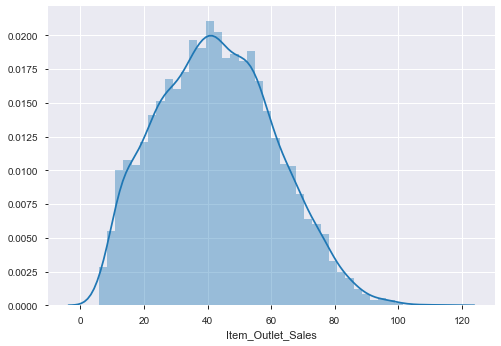

In [27]:
sns.distplot(np.sqrt(train_df['Item_Outlet_Sales']))

In [28]:
train_df.select_dtypes(exclude ='float64') 

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Years
0,FDA15,Low Fat,Dairy,OUT049,1999,Medium,Tier 1,Supermarket Type1,14
1,DRC01,Regular,Soft Drinks,OUT018,2009,Medium,Tier 3,Supermarket Type2,4
2,FDN15,Low Fat,Meat,OUT049,1999,Medium,Tier 1,Supermarket Type1,14
3,FDX07,Regular,Fruits and Vegetables,OUT010,1998,Medium,Tier 3,Grocery Store,15
4,NCD19,Low Fat,Household,OUT013,1987,High,Tier 3,Supermarket Type1,26
...,...,...,...,...,...,...,...,...,...
8518,FDF22,Low Fat,Snack Foods,OUT013,1987,High,Tier 3,Supermarket Type1,26
8519,FDS36,Regular,Baking Goods,OUT045,2002,Small,Tier 2,Supermarket Type1,11
8520,NCJ29,Low Fat,Health and Hygiene,OUT035,2004,Small,Tier 2,Supermarket Type1,9
8521,FDN46,Regular,Snack Foods,OUT018,2009,Medium,Tier 3,Supermarket Type2,4


In [29]:
#Get the first two characters of ID:
train_df['Item_Type_Combined'] = train_df['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
train_df['Item_Type_Combined'] = train_df['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
train_df['Item_Type_Combined'].value_counts()

Food              6125
Non-Consumable    1599
Drinks             799
Name: Item_Type_Combined, dtype: int64

In [30]:
test_df['Item_Type_Combined'] = test_df['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
test_df['Item_Type_Combined'] = test_df['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
test_df['Item_Type_Combined'].value_counts()

Food              4076
Non-Consumable    1087
Drinks             518
Name: Item_Type_Combined, dtype: int64

In [31]:
train_df.loc[train_df['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
train_df['Item_Fat_Content'].value_counts()

Low Fat       3918
Regular       3006
Non-Edible    1599
Name: Item_Fat_Content, dtype: int64

In [32]:
test_df.loc[test_df['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
test_df['Item_Fat_Content'].value_counts()

Low Fat       2581
Regular       2013
Non-Edible    1087
Name: Item_Fat_Content, dtype: int64

In [33]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Years,Item_Type_Combined
0,FDA15,9.3000,Low Fat,0.0160,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14,Food
1,DRC01,5.9200,Regular,0.0193,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,4,Drinks
2,FDN15,17.5000,Low Fat,0.0168,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14,Food
3,FDX07,19.2000,Regular,0.0178,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,15,Food
4,NCD19,8.9300,Non-Edible,0.0098,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,26,Non-Consumable


In [39]:
func = lambda x: x['Item_Visibility']/visibility_avg[visibility_avg.index == x['Item_Identifier']][0]
train_df['Item_Visibility_MeanRatio'] = train_df.apply(func,axis=1).astype(float)
train_df['Item_Visibility_MeanRatio'].describe()

count   8523.0000
mean       1.0630
std        0.2397
min        0.8504
25%        0.9251
50%        0.9991
75%        1.0420
max        3.0101
Name: Item_Visibility_MeanRatio, dtype: float64

In [40]:
test_df['Item_Visibility_MeanRatio'] = test_df.apply(func,axis=1).astype(float)
test_df['Item_Visibility_MeanRatio'].describe()

count   5681.0000
mean       1.0602
std        0.2300
min        0.8446
25%        0.9251
50%        0.9991
75%        1.0425
max        2.0776
Name: Item_Visibility_MeanRatio, dtype: float64

In [ ]:
Check

In [41]:
train_df['Item_Outlet_Sales'] = np.sqrt(train_df['Item_Outlet_Sales'])

In [42]:
#drop_cols =['Outlet_Establishment_Year','Outlet_Size','Item_Type','Item_Fat_Content']
drop_cols=['Outlet_Establishment_Year','Item_Identifier']

In [43]:
train_df.drop(drop_cols,axis=1,inplace=True)
test_df.drop(drop_cols,axis=1,inplace=True)

In [44]:
X = train_df.drop(['Outlet_Identifier'], axis=1, inplace=True)
test_df.drop(['Outlet_Identifier'], axis=1, inplace=True)
X = train_df.drop(['Item_Outlet_Sales'], axis=1)
y = train_df['Item_Outlet_Sales']

In [45]:
categories = list(train_df.select_dtypes(include ='object').columns)
categories

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Type_Combined']

In [46]:
from feature_engine import categorical_encoders as ce

In [47]:
#encoder = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency', variables =categories)
encoder = ce.OneHotCategoricalEncoder(variables =categories,drop_last=False)

In [48]:
encoder.fit(X,y)

OneHotCategoricalEncoder(drop_last=False, top_categories=20,
                         variables=['Item_Fat_Content', 'Item_Type',
                                    'Outlet_Size', 'Outlet_Location_Type',
                                    'Outlet_Type', 'Item_Type_Combined'])

In [49]:
X = encoder.transform(X)


In [50]:
X.head()

,Item_Weight,Item_Visibility,Item_MRP,Years,Item_Visibility_MeanRatio,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_Non-Edible,Item_Type_Fruits and Vegetables,Item_Type_Snack Foods,...,Outlet_Location_Type_Tier 3,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 1,Outlet_Type_Supermarket Type1,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3,Outlet_Type_Supermarket Type2,Item_Type_Combined_Food,Item_Type_Combined_Non-Consumable,Item_Type_Combined_Drinks
0,9.3000,0.0160,249.8092,14,0.9311,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1,5.9200,0.0193,48.2692,4,0.9334,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
2,17.5000,0.0168,141.6180,14,0.9601,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
3,19.2000,0.0178,182.0950,15,1.0000,0,1,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,8.9300,0.0098,53.8614,26,1.0000,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0


In [51]:
test_df = encoder.transform(test_df)

In [52]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 37 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Item_Weight                        5681 non-null   float64
 1   Item_Visibility                    5681 non-null   float64
 2   Item_MRP                           5681 non-null   float64
 3   Years                              5681 non-null   int64  
 4   Item_Visibility_MeanRatio          5681 non-null   float64
 5   Item_Fat_Content_Low Fat           5681 non-null   int32  
 6   Item_Fat_Content_Regular           5681 non-null   int32  
 7   Item_Fat_Content_Non-Edible        5681 non-null   int32  
 8   Item_Type_Fruits and Vegetables    5681 non-null   int32  
 9   Item_Type_Snack Foods              5681 non-null   int32  
 10  Item_Type_Household                5681 non-null   int32  
 11  Item_Type_Frozen Foods             5681 non-null   int32

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [54]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import learning_curve
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error

In [55]:
def residual_plot(model,X_train, y_train,X_validation, y_validation):
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure

In [56]:
def prediction_error(model,X_train, y_train,X_validation, y_validation):
    visualizer = PredictionError(model)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
    visualizer.show()   

In [57]:
def show_learning_curve(model,X_train, y_train,X_validation, y_validation):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X_train, y_train.values.ravel(), cv=5)
    plot_learning_curve(train_sizes, train_scores, validation_scores)

In [80]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.1,max_depth=5,colsample_bylevel=0.7)
my_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_validation,y_validation)], verbose=False)

[09:41:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

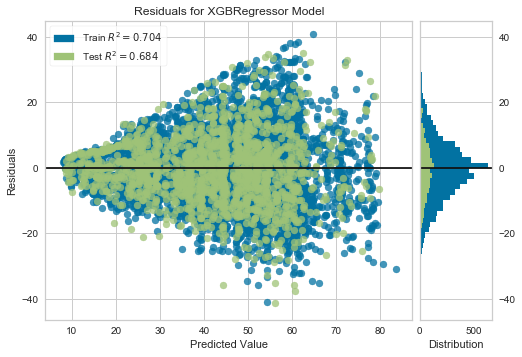

In [81]:
residual_plot(my_model,X_train, y_train,X_validation, y_validation)

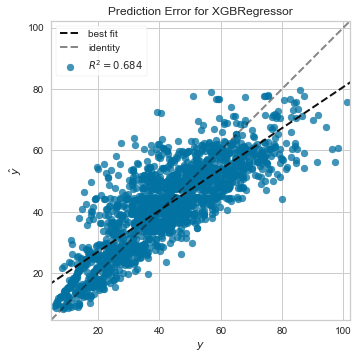

In [82]:
prediction_error(my_model,X_train, y_train,X_validation, y_validation)

In [83]:
y_pred_val = my_model.predict(X_validation)
mean_squared_error(np.square(y_validation), np.square(y_pred_val),squared=False)

1046.091996634268

In [72]:
y_test =  np.square(my_model.predict(test_df)) 

In [ ]:
check

In [84]:
 
submission = pd.DataFrame()
submission['Item_Identifier'] = test_df_copy['Item_Identifier']
submission['Outlet_Identifier'] = test_df_copy['Outlet_Identifier']
submission['Item_Outlet_Sales'] = y_test * 0.5  
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="Submission_Regression_"+timestamp+"_out.csv"
submission.to_csv(filename,index=False)

In [ ]:
# grid = {'learning_rate': [0.03,0.08,0.5, 0.1],
#        'depth': [3,4, 6,],
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

#grid_search_result = model.fit(X_train,y_train,cat_features=cat_features,eval_set=(X_validation,y_validation),plot=True)